# Relationship Extraction

In this notebook, we will implement a Relation Extraction Model using BERT and Pytorch.

### Data

* This dataset contains 3 types of relations that may occur in a sentence.
    * pro
    * con
    * neutral
* The relationships connect three different entity types SOURCE, TARGET and PEXP (POLARITY EXPRESSION). 

### Model

* Unlike the `XXXForTokenClassification` model, which comes with a standard token classification head on top of some XXX transformer, there is no pre-built model available OOB at HuggingFace for Relation Extraction.
* So we will build our own `XXXForRelationExtraction` model by composing a pretrained Transformer encoder with a classification head for classifying the relation type.

## Imports

In [1]:
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import re
import shutil
import torch
import torch.nn as nn

from collections import Counter, defaultdict
from datasets import load_dataset, ClassLabel
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix, 
    classification_report, accuracy_score
)
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim import AdamW

from transformers import (
    BertTokenizerFast, BertModel, BertForPreTraining, BertConfig, BertPreTrainedModel,
    DataCollatorWithPadding,
    get_scheduler
)
from transformers.modeling_outputs import SequenceClassifierOutput

/home/user/massey/envs/nbdev/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
# GS_INPUT_DIR = "/content/drive/MyDrive/odsc-2022-data/NYT"
DATA_DIR = "../../etl/data/processed/REConverter"
splits = ["train", "test", "val"]
# BASE_MODEL_NAME = "xlm-roberta-base"
BASE_MODEL_NAME = "bert-base-german-cased"
MODEL_DIR = os.path.join("./data", "{:s}-re".format(BASE_MODEL_NAME))

MODEL_EPOCH_VERSION=1

### Load the dataset

We need a dataset where each line consists of the following properties:

```
{"tokens": [a, b, c, ...], "label": "pro"}
{"tokens": [a, c, x, ...], "label": "con"}
```

In [3]:
data_files = {split: os.path.join(DATA_DIR, "01_{:s}_re.json".format(split)) for split in splits}
nyt_dataset = load_dataset("json", data_files=data_files)
nyt_dataset

Using custom data configuration default-ab15ced31ed3264a


Extracting data files: 100%|██████████| 3/3 [00:00<00:00, 729.28it/s]
                            

Dataset json downloaded and prepared to /home/user/massey/.cache/huggingface/datasets/json/default-ab15ced31ed3264a/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 441.13it/s]


DatasetDict({
    train: Dataset({
        features: ['tokens', 'label'],
        num_rows: 3816
    })
    test: Dataset({
        features: ['tokens', 'label'],
        num_rows: 1380
    })
    val: Dataset({
        features: ['tokens', 'label'],
        num_rows: 1365
    })
})

### Label Distribution

Even with the filtering, the label distribution is not uniform. However, it is not as bad as it would be if no filtering was done.

In [4]:
nyt_dataset.set_format(type="pandas")
nyt_df = nyt_dataset["train"][:]
nyt_df.head()

,tokens,label
0,"[Die, <eSOURCE>, Grasshoppers, </eSOURCE>, <eP...",Negative
1,"[Als, sich, <eSOURCE>, Prinzessin, </eSOURCE>,...",Positive
2,"[<eSOURCE>, Maurer, </eSOURCE>, <ePEXP>, errei...",Positive
3,"[Allerdings, reagiert, er, trotzig, –, und, da...",Positive
4,"[Den, <eTARGET>, Kraftwerksbetreibern, </eTARG...",Negative


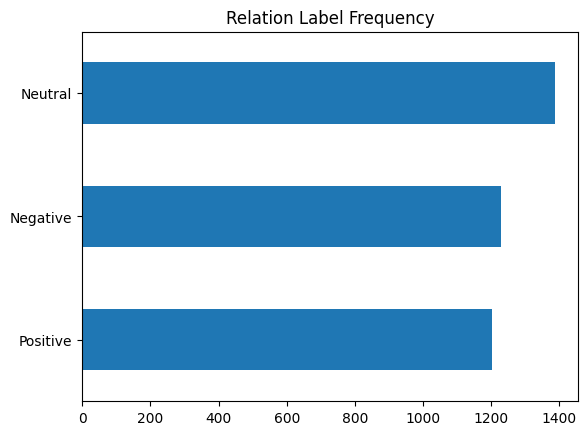

In [5]:
nyt_df["label"].value_counts(ascending=True).plot.barh()
plt.title("Relation Label Frequency")
_ = plt.show()

### Sentence Length Distribution

We were encountering errors where we were running out of CUDA Memory. This was happening even when I reduced the batch size from 32 to 8. The other reason this could be happening is that some batches might contain very long outlier sentences and this causes the batch to be too big for the GPU memory.

Solution is to truncate the sentence size to a size that will not impact the accuracy too much. 

The box plots below shows that we won't lose too many samples if we ignore sentences that are over 100 tokens in length.

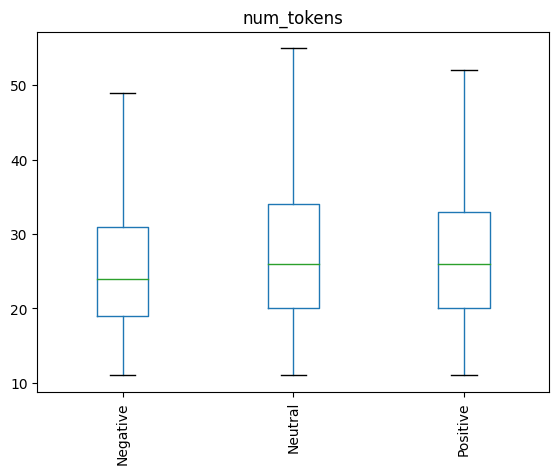

In [6]:
nyt_df["num_tokens"] = nyt_df["tokens"].apply(len)
nyt_df.boxplot("num_tokens", by="label", grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.xticks(rotation=90)
_ = plt.show()

In [7]:
nyt_dataset.reset_format()

## Tokenizer

In [8]:
tokenizer = BertTokenizerFast.from_pretrained(BASE_MODEL_NAME)
vocab_size_orig = len(tokenizer.vocab)

### Add Entity Marker Tokens

Now that we added these entity marker tokens, we need to tell the tokenizer to treat them as unbreakable tokens, so we add these tokens to our tokenizer.

In [9]:
marker_tokens = []
entity_types = ["eSOURCE", "eTARGET", "ePEXP"]
for entity_type in entity_types:
  marker_tokens.append("<{:s}>".format(entity_type))
  marker_tokens.append("</{:s}>".format(entity_type))

tokenizer.add_tokens(marker_tokens)
vocab_size_new = len(tokenizer.vocab)

print("original vocab size:", vocab_size_orig)
print("new vocab size:", vocab_size_new)

original vocab size: 30000
new vocab size: 30006


In [10]:
marker_tokens

['<eSOURCE>', '</eSOURCE>', '<eTARGET>', '</eTARGET>', '<ePEXP>', '</ePEXP>']

## Encoded Dataset

As before, we create an encoded dataset that contains the output of the tokenizer and numeric labels.

To compute numeric labels, we create a `ClassLabel` object with our relation tags, and use its built-in functions to create lookup tables from label to label id and vice versa.

We discard sentences that are larger than `MAX_TOKENS` which we have decided should be 100 tokens (these are space delimited tokens prior to subword tokenization).

In addition, we also compute and store the value of the entity marker tokens with respect to the positions _after subword tokenization_. This is written into a fixed size int vector consisting of 4 elements, and stored under the `span_idxs` key.

In [11]:
valid_relations = ["Positive", "Neutral", "Negative"]
valid_relations = sorted(list(valid_relations))
rel_tags = ClassLabel(names=valid_relations)
label2id = {name: rel_tags.str2int(name) for name in valid_relations}
id2label = {id: rel_tags.int2str(id) for id in range(len(valid_relations))}

# label2id, id2label

In [12]:
def encode_data(examples):
  tokenized_inputs = tokenizer(examples["tokens"],
                               is_split_into_words=True,
                               truncation=True)
  span_idxs = []
  for input_id in tokenized_inputs.input_ids:
    tokens = tokenizer.convert_ids_to_tokens(input_id)
    try:
        span_idxs.append([
          [idx for idx, token in enumerate(tokens) if token.startswith("<eS")][0],
          [idx for idx, token in enumerate(tokens) if token.startswith("</eS")][0],
          [idx for idx, token in enumerate(tokens) if token.startswith("<eT")][0],
          [idx for idx, token in enumerate(tokens) if token.startswith("</eT")][0],
          [idx for idx, token in enumerate(tokens) if token.startswith("<eP")][0],
          [idx for idx, token in enumerate(tokens) if token.startswith("</eP")][0],
        ])
    except Exception as e:
        print(f"Encountered error because of: { str(e) }")
        # from IPython.core.debugger import Pdb; Pdb().set_trace()
        # print(f"Tokens of sentence: { str(examples['tokens']) }")

  tokenized_inputs["span_idxs"] = span_idxs
  tokenized_inputs["labels"] = [label2id[label] for label in examples["label"]]
  return tokenized_inputs

encoded = encode_data(nyt_dataset["train"][0:5])
encoded.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'span_idxs', 'labels'])

In [13]:
MAX_LENGTH = 100
encoded_nyt_dataset = (nyt_dataset
                       .filter(lambda example: len(example["tokens"]) < MAX_LENGTH)
                       .map(encode_data, batched=True, remove_columns=["tokens", "label"]))
encoded_nyt_dataset

 50%|█████     | 1/2 [00:00<00:00, 23.34ba/s]
Parameter 'function'=<function encode_data at 0x7f0e817716a8> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
 50%|█████     | 1/2 [00:00<00:00,  2.95ba/s]


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'span_idxs', 'labels'],
        num_rows: 3812
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'span_idxs', 'labels'],
        num_rows: 1380
    })
    val: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'span_idxs', 'labels'],
        num_rows: 1364
    })
})

In [14]:
rec = encoded_nyt_dataset["train"][0:5]
print("rec.labels:", rec["labels"])
print("rec.input_ids:", len(rec["input_ids"]), len(rec["input_ids"][0]))
print("rec.span_idxs:", rec["span_idxs"])

rec.labels: [0, 2, 2, 2, 0]
rec.input_ids: 5 19
rec.span_idxs: [[2, 6, 13, 15, 7, 9], [3, 5, 11, 13, 14, 16], [1, 3, 20, 24, 4, 6], [28, 32, 39, 41, 23, 26], [16, 19, 2, 8, 9, 11]]


## DataLoader

As we have done before in our NER notebooks (the ones using PyTorch native idioms), we build `DataLoaders` for each of training, validation and test splits by wrapping the corresponding encoded `Dataset`.

We use a `DataColatorWithPadding` data collator to automatically pad our batch with the longest sentence in the batch.

Also as before, we have used the `sampler` trick for doing quick development iterations by keeping the data volume down.

In [15]:
BATCH_SIZE = 16

In [16]:
collate_fn = DataCollatorWithPadding(tokenizer, padding="longest", return_tensors="pt")

train_dl = DataLoader(encoded_nyt_dataset["train"], 
                      shuffle=True, 
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_nyt_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE, 
                      collate_fn=collate_fn)
valid_dl = DataLoader(encoded_nyt_dataset["val"], 
                      shuffle=False, 
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_nyt_dataset["valid"].num_rows, 200).tolist()),
                      batch_size=BATCH_SIZE, 
                      collate_fn=collate_fn)
test_dl = DataLoader(encoded_nyt_dataset["test"], 
                     shuffle=False,
                     #  sampler=SubsetRandomSampler(np.random.randint(0, encoded_nyt_dataset["test"].num_rows, 100).tolist()),
                     batch_size=BATCH_SIZE, 
                     collate_fn=collate_fn)

## Model

Since HuggingFace does not provide us with a built-in `XXXForRelationExtraction` model, we need to build our own. Our model is based on the implementation described in [A frustratingly easy approach for Entity and Relation Extraction](https://arxiv.org/abs/2010.12812) (Zhong and Chen 2020). The authors also provide code in the github repository [princeton-nlp/PURE](https://github.com/princeton-nlp/PURE) to support their paper, which we have consulted as well when building our model.

The idea is to use a PreTrainedModel as the encoder and a small linear head consisting of `torch.nn.Dropout`, `torch.nn.LayerNorm` and `torch.nn.Linear` layers as the classifier head. The encoder should start with weights from the pretrained model and be fine-tuned from that point using our labeled data.

Since our base model is BERT, we will use a `BertModel` as our encoder and subclass the full model from `BertPreTrainedModel` so we can inherit its weights via the `self.init_weights()` call. When instantiating the model, we will first instantiate the `BertConfig` class with the appropriate `from_pretrained` model, then instantiate our custom `BertForRelationExtraction` with the weights of its superclass also using `from_pretrained`.

Finally, we will increase the size of the BERT encoder's embedding matrix to accomodate the extra entity marker tokens we added to the tokenizer vocabulary.

The `forward` method takes a batch of examples from the encoded dataset, and passes the `input_ids`, `token_type_ids` and `attention_mask` into the BERT encoder (initialized with BertForPreTraining weights). Then the maxpool value across tokens within the entity marker spans (including the entity markers) are computed for the subject and object spans, concatenated and passed into the classifier head.

The classifier head outputs a logits vector the size of the number of classes, and the argmax over the logits is the predicted relation class.

In [17]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
class BertForRelationExtraction(BertPreTrainedModel):
  def __init__(self, config, num_labels):
    super(BertForRelationExtraction, self).__init__(config)
    self.num_labels = num_labels
    # body
    self.bert = BertModel(config)
    # head
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    #self.layer_norm = nn.LayerNorm(config.hidden_size * 2)
    #self.linear = nn.Linear(config.hidden_size * 2, self.num_labels)
    self.init_weights()
    
    self.layer_norm = nn.LayerNorm(config.hidden_size * 3)
    self.linear = nn.Linear(config.hidden_size * 3, self.num_labels)

  def forward(self, input_ids, token_type_ids, attention_mask,
              span_idxs, labels=None):
    outputs = (
        self.bert(input_ids, token_type_ids=token_type_ids,
                  attention_mask=attention_mask,
                  output_hidden_states=False)
            .last_hidden_state)
            
    sub_maxpool, obj_maxpool, pexp_maxpool = [], [], []
    #sub_maxpool, obj_maxpool = [], []
    for bid in range(outputs.size(0)):
      # span includes entity markers, maxpool across span
      sub_span = torch.max(outputs[bid, span_idxs[bid, 0]:span_idxs[bid, 1]+1, :], 
                           dim=0, keepdim=True).values
      obj_span = torch.max(outputs[bid, span_idxs[bid, 2]:span_idxs[bid, 3]+1, :],
                           dim=0, keepdim=True).values
      pexp_span = torch.max(outputs[bid, span_idxs[bid, 4]:span_idxs[bid, 5]+1, :], dim=0, keepdim=True).values
      sub_maxpool.append(sub_span)
      obj_maxpool.append(obj_span)
      pexp_maxpool.append(pexp_span)

    sub_emb = torch.cat(sub_maxpool, dim=0)
    obj_emb = torch.cat(obj_maxpool, dim=0)
    pexp_emb = torch.cat(pexp_maxpool, dim=0)
    rel_input = torch.cat((sub_emb, obj_emb, pexp_emb), dim=-1)
    #rel_input = torch.cat((sub_emb, obj_emb), dim=-1)

    rel_input = self.layer_norm(rel_input)
    rel_input = self.dropout(rel_input)
    logits = self.linear(rel_input)

    if labels is not None:
      loss_fn = nn.CrossEntropyLoss()
      loss = loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
      return SequenceClassifierOutput(loss, logits)
    else:
      return SequenceClassifierOutput(None, logits)


# config = BertConfig.from_pretrained(BASE_MODEL_NAME)
# model = BertForRelationExtraction.from_pretrained(BASE_MODEL_NAME, 
#                                                   config=config,
#                                                   num_labels=len(valid_relations))
# model.bert.resize_token_embeddings(len(tokenizer.vocab))
# for batch in train_dl:
#   outputs = model(**batch)
#   break
# print("loss:", outputs.loss, "logits.size:", outputs.logits.size())

## Training Loop

In [19]:
# 5e-5 before!
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 1e-2
NUM_EPOCHS = 3

In [20]:
config = BertConfig.from_pretrained(BASE_MODEL_NAME)
model = BertForRelationExtraction.from_pretrained(BASE_MODEL_NAME, 
                                                  config=config,
                                                  num_labels=len(valid_relations))
model.bert.resize_token_embeddings(len(tokenizer.vocab))
model = model.to(device)

optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  weight_decay=WEIGHT_DECAY)

num_training_steps = NUM_EPOCHS * len(train_dl)
lr_scheduler = get_scheduler("linear",
                             optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=num_training_steps)

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForRelationExtraction: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForRelationExtraction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForRelationExtraction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForRelationExtraction were not initialized from the model checkpoint at bert-base-

In [21]:
from tqdm import tqdm

def compute_accuracy(labels, logits):
  preds_cpu = torch.argmax(logits, dim=-1).cpu().numpy()
  labels_cpu = labels.cpu().numpy()
  return accuracy_score(labels_cpu, preds_cpu)


def do_train(model, train_dl):
  train_loss = 0
  model.train()
  with tqdm(train_dl, unit="batch") as tepoch:
      for bid, batch in enumerate(tepoch):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.detach().cpu().numpy()
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

  return train_loss


def do_eval(model, eval_dl):
  model.eval()
  eval_loss, eval_score, num_batches = 0, 0, 0
  with tqdm(eval_dl, unit="batch") as eepoch:
      for bid, batch in enumerate(eepoch):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
          outputs = model(**batch)

        loss = outputs.loss

        eval_loss += loss.detach().cpu().numpy()
        eval_score += compute_accuracy(batch["labels"], outputs.logits)
        num_batches += 1

  eval_score /= num_batches
  return eval_loss, eval_score


def save_checkpoint(model, model_dir, epoch):
  model.save_pretrained(os.path.join(MODEL_DIR, "ckpt-{:d}".format(epoch)))


def save_training_history(history, model_dir, epoch):
  fhist = open(os.path.join(MODEL_DIR, "history.tsv"), "w")
  for epoch, train_loss, eval_loss, eval_score in history:
    fhist.write("{:d}\t{:.5f}\t{:.5f}\t{:.5f}\n".format(
        epoch, train_loss, eval_loss, eval_score))
  fhist.close()

## Training / Fine-tuning

In [22]:
if os.path.exists(MODEL_DIR):
  shutil.rmtree(MODEL_DIR)
  os.makedirs(MODEL_DIR)

history = []

for epoch in range(NUM_EPOCHS):
  train_loss = do_train(model, train_dl)
  eval_loss, eval_score = do_eval(model, valid_dl)
  history.append((epoch + 1, train_loss, eval_loss, eval_score))
  print("EPOCH {:d}, train loss: {:.3f}, val loss: {:.3f}, val-acc: {:.5f}".format(
      epoch + 1, train_loss, eval_loss, eval_score))
  save_checkpoint(model, MODEL_DIR, epoch + 1)
  save_training_history(history, MODEL_DIR, epoch + 1)

100%|██████████| 86/86 [00:05<00:00, 14.98batch/s]


EPOCH 1, train loss: 122.332, val loss: 88.679, val-acc: 0.59666


100%|██████████| 86/86 [00:05<00:00, 14.89batch/s]


EPOCH 2, train loss: 40.968, val loss: 102.083, val-acc: 0.57776


100%|██████████| 86/86 [00:05<00:00, 14.87batch/s]


EPOCH 3, train loss: 21.171, val loss: 103.134, val-acc: 0.59738


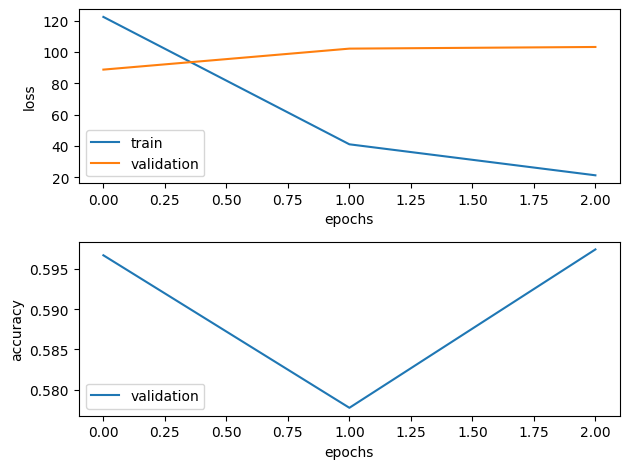

In [23]:
plt.subplot(2, 1, 1)
plt.plot([train_loss for _, train_loss, _, _ in history], label="train")
plt.plot([eval_loss for _, _, eval_loss, _ in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot([eval_score for _, _, _, eval_score in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")

plt.tight_layout()
_ = plt.show()

## Evaluation

In [24]:
ytrue, ypred = [], []
with tqdm(test_dl, unit="batch") as tepoch:
    for batch in tepoch:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
          outputs = model(**batch)
          predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
          labels = batch["labels"].cpu().numpy()
          ytrue.extend(labels)
          ypred.extend(predictions)

print("test accuracy: {:.3f}".format(accuracy_score(ytrue, ypred)))

100%|██████████| 87/87 [00:05<00:00, 14.60batch/s]

test accuracy: 0.585


In [25]:
print(classification_report(ytrue, ypred, target_names=valid_relations))

              precision    recall  f1-score   support

    Negative       0.78      0.41      0.54       473
     Neutral       0.44      0.92      0.59       412
    Positive       0.89      0.47      0.62       495

    accuracy                           0.58      1380
   macro avg       0.70      0.60      0.58      1380
weighted avg       0.72      0.58      0.58      1380



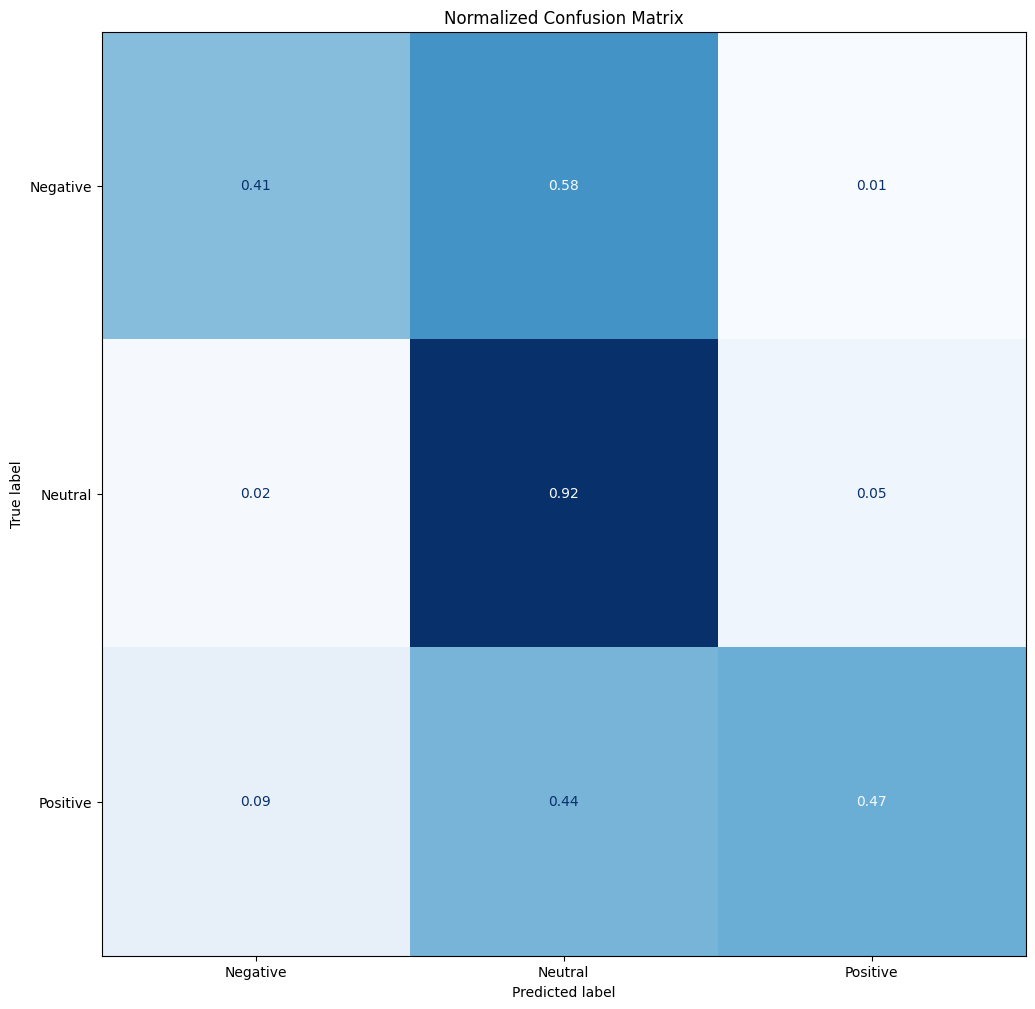

In [26]:
def plot_confusion_matrix(ytrue, ypreds, labels):
  cm = confusion_matrix(ytrue, ypreds, normalize="true")
  fig, ax = plt.subplots(figsize=(12, 12))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format="0.2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  _ = plt.show()


plot_confusion_matrix(ytrue, ypred, valid_relations)

## Inference

Load a model and perform inference on some data.

In [29]:
from tqdm import tqdm

checkpoint_file = os.path.join(MODEL_DIR, "ckpt-{:d}".format(MODEL_EPOCH_VERSION))

print("=> Loading checkpoint")
# checkpoint = model.from_pretrained(checkpoint_file)
config = BertConfig.from_pretrained(checkpoint_file)
model = BertForRelationExtraction.from_pretrained(checkpoint_file, 
                      config=config,
                      num_labels=len(valid_relations))
# model.load_state_dict(checkpoint["state_dict"])
model.bert.resize_token_embeddings(len(tokenizer.vocab))
model.eval()
model = model.to(device)

# optimizer.load_state_dict(checkpoint["optimizer"])

# If we don't do this then it will just have learning rate of old checkpoint
# and it will lead to many hours of debugging \:
# for param_group in optimizer.param_groups:
#    param_group["lr"] = lr

ytrue, ypred = [], []
with tqdm(test_dl, unit="batch") as tepoch:
    for batch in tepoch:
        # print(batch)
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
          outputs = model(**batch)
          predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
          labels = batch["labels"].cpu().numpy()
          ytrue.extend(labels)
          ypred.extend(predictions)

print("test accuracy: {:.3f}".format(accuracy_score(ytrue, ypred)))

print(classification_report(ytrue, ypred, target_names=valid_relations))

=> Loading checkpoint


100%|██████████| 87/87 [00:05<00:00, 14.76batch/s]

test accuracy: 0.582
              precision    recall  f1-score   support

    Negative       0.77      0.39      0.52       473
     Neutral       0.44      0.90      0.59       412
    Positive       0.85      0.49      0.63       495

    accuracy                           0.58      1380
   macro avg       0.69      0.60      0.58      1380
weighted avg       0.70      0.58      0.58      1380

